In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2, VGG16, InceptionV3, Xception, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten, LSTM, Dense, Input, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import os
import numpy as np
import matplotlib.pyplot as plt
from imageio import get_reader
from cv2 import resize
from IPython.display import Video

In [2]:
import random
from sklearn.model_selection import train_test_split

In [3]:
def resnet_feature_extractor(img_size):
    height, width = img_size
    b_model = ResNet50V2(weights='imagenet', include_top = False, input_shape=(height, width, 3))
    x = GlobalAveragePooling2D()(b_model.output)
    x = Flatten()(x)
    feature_extractor = Model(inputs = b_model.input, outputs = x)
    return feature_extractor

In [4]:
root = r'C:\Users\chakumar\CV Projects\BadmintonShotDetection'

In [5]:
def video_to_image(video_path, fps, target_size):
    imgs_as_np = []
    vid = get_reader(video_path, format='ffmpeg', fps= fps)
    for frame in vid:
        h, w = target_size
        img_array = resize(frame, (w, h))
        imgs_as_np.append(img_array)
    return np.array(imgs_as_np)

In [6]:
def video_to_features(feature_extractor, video_path, fps, target_size):
    imgs_as_np = video_to_image(video_path, fps, target_size)
    preprocessed_images = preprocess_input(imgs_as_np)
    video_features = feature_extractor.predict(preprocessed_images)
    return video_features

In [7]:
def plot_model_history(model_summary):
    plt.plot(model_summary.history['loss'])
    plt.plot(model_summary.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'],loc='upper right')
    plt.show()

In [8]:
videofiles=[]
for file in os.listdir("./ShotVideoData/"):
    video_path = os.path.join(root, "ShotVideoData", file)
    videofiles.append({'file_dir': video_path,'label': 1})
    
for file in os.listdir("./notShotVideoData/"):
    video_path = os.path.join(root,"notShotVideoData",file)
    videofiles.append({'file_dir': video_path,'label': 0})

In [25]:
def LSTMclassifier(input_shape):
    input_layer = Input(shape=input_shape)
    X = LSTM(units = 32, return_sequences = True)(input_layer)
    X = LSTM(units = 32)(X)
    Y = Dense(1, activation='sigmoid')(X)
    return Model(inputs = input_layer, outputs = Y)

In [9]:
def classifier_performances(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("\nClassification Report:\n", class_report)

In [11]:
video_data = list(videofiles)
random.shuffle(video_data)
img_size = (224, 224)
resnetv2 = resnet_feature_extractor(img_size)
fps = 10
input_data, labels = [], []
for data in video_data:
    video_path, label = data['file_dir'], data['label']
    video_features = video_to_features(resnetv2, video_path, fps, target_size = img_size)
    input_data.append(video_features)
    labels.append(label)
np.savez("input_data.npz", np.array(input_data))
np.savez("labels.npz", np.array(labels))

2/2 [==============================] - 2s 838ms/step


2/2 [==============================] - 2s 872ms/step


2/2 [==============================] - 2s 849ms/step


In [16]:
input_data = np.load("input_data.npz")["arr_0"]
labels = np.load("labels.npz")["arr_0"]
x_train, x_test, y_train, y_test = train_test_split(np.array(input_data), np.array(labels), test_size = 0.2, random_state = 42)

Epoch 1/50
34/34 [==============================] - 12s 169ms/step - loss: 0.7421 - accuracy: 0.3865 - val_loss: 0.7198 - val_accuracy: 0.4701
Epoch 2/50
34/34 [==============================] - 4s 113ms/step - loss: 0.6948 - accuracy: 0.5403 - val_loss: 0.6821 - val_accuracy: 0.5970
Epoch 3/50
34/34 [==============================] - 4s 121ms/step - loss: 0.6571 - accuracy: 0.6454 - val_loss: 0.6488 - val_accuracy: 0.6642
Epoch 4/50
34/34 [==============================] - 4s 130ms/step - loss: 0.6262 - accuracy: 0.6735 - val_loss: 0.6221 - val_accuracy: 0.6940
Epoch 5/50
34/34 [==============================] - 4s 115ms/step - loss: 0.6009 - accuracy: 0.7054 - val_loss: 0.5982 - val_accuracy: 0.6940
Epoch 6/50
34/34 [==============================] - 4s 107ms/step - loss: 0.5806 - accuracy: 0.7148 - val_loss: 0.5788 - val_accuracy: 0.7090
Epoch 7/50
34/34 [==============================] - 4s 111ms/step - loss: 0.5629 - accuracy: 0.7448 - val_loss: 0.5628 - val_accuracy: 0.7313
Epoch

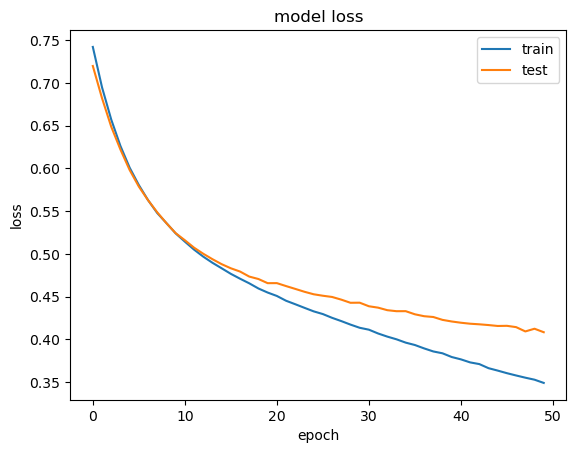

In [26]:
input_shape = (x_train.shape[1], x_train.shape[2])
decoder = LSTMclassifier(input_shape)
decoder.compile(optimizer = Adam(learning_rate = 0.00001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_summary = decoder.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 50, batch_size = 16)
plot_model_history(model_summary)

Video("./ShotVideoData/Badminton2023_1025.mp4")